In [ ]:
pip install transformers

     |████████████████████████████████| 4.2 MB 5.0 MB/s 
     |████████████████████████████████| 596 kB 56.1 MB/s 
     |████████████████████████████████| 6.6 MB 35.9 MB/s 
     |████████████████████████████████| 84 kB 3.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from tensorflow.keras import utils as np_utils
from keras.utils.np_utils import to_categorical

import transformers
from transformers import AutoTokenizer,TFDistilBertModel, DistilBertConfig
from transformers import TFAutoModel

import warnings
warnings.filterwarnings("ignore")

In [ ]:

print(tf.__version__)
print(keras.__version__)

2.8.0
2.8.0


In [ ]:
df = pd.read_csv('products_clean.csv', header=0,index_col=0)
df.head()

,product_type,description
0,lipstic,lippie pencil long wearing high intensity lip ...
1,lipstic,blotted lip sheer matte lipstick creates perfe...
2,lipstic,lippie stix formula contains vitamin e mango a...
3,foundation,developed selfie age buildable full coverage n...
4,lipstic,product free lead heavy metal parabens phthala...


In [ ]:

df.shape


(906, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 906 entries, 0 to 930
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_type  906 non-null    object
 1   description   906 non-null    object
dtypes: object(2)
memory usage: 21.2+ KB


In [ ]:
df['product_type'].value_counts()

eye_makeup     367
lipstic        176
foundation     159
contour        144
nail_polish     60
Name: product_type, dtype: int64

In [ ]:
X = df['description']
y = df['product_type']

In [ ]:

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

In [ ]:
encoder = LabelEncoder()
encoder.fit(y_train)

y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

num_classes = np.max(y_train) + 1
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
bert = TFAutoModel.from_pretrained('distilbert-base-uncased')


Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_projector', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:

for layer in bert.layers:
      layer.trainable = True


In [ ]:
# Tokenization of the data
def text_encode(text, tokenizer, max_len=100):
    tokens = text.apply(lambda x: tokenizer(x,return_tensors='tf',
                                            truncation=True,
                                            padding='max_length',
                                            max_length=max_len,
                                            add_special_tokens=True))
    input_ids= []
    attention_mask=[]
    for item in tokens:
        input_ids.append(item['input_ids'])
        attention_mask.append(item['attention_mask'])
    input_ids, attention_mask=np.squeeze(input_ids), np.squeeze(attention_mask)

    return [input_ids,attention_mask]


In [ ]:
X_train_input_ids, X_train_attention_mask = text_encode(X_train, tokenizer, max_len=100)
X_test_input_ids, X_test_attention_mask = text_encode(X_test, tokenizer, max_len=100)


In [ ]:
# model creation
def build_model(bert_model, maxlen=100):
   input_ids = tf.keras.Input(shape=(maxlen,),dtype=tf.int32, name='input_ids')
   attention_mask = tf.keras.Input(shape=(maxlen,),dtype=tf.int32, name='attention_mask')

   sequence_output = bert_model(input_ids,attention_mask=attention_mask)
   output = sequence_output[0][:,0,:]
   output = tf.keras.layers.Dense(32,activation='relu')(output)
   output = tf.keras.layers.Dropout(0.2)(output)
   output = tf.keras.layers.Dense(5,activation='softmax')(output)

   model = tf.keras.models.Model(inputs = [input_ids,attention_mask], outputs = [output])
   model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

   return model


In [ ]:
model = build_model(bert, maxlen=100)

In [ ]:
history = model.fit(
    [X_train_input_ids, X_train_attention_mask],
    y_train,
    batch_size=32,
    validation_data=([X_test_input_ids, X_test_attention_mask], y_test),
    epochs=10
)

Epoch 1/10
23/23 [==============================] - 431s 18s/step - loss: 1.4727 - accuracy: 0.3826 - val_loss: 1.3250 - val_accuracy: 0.4890
Epoch 2/10
23/23 [==============================] - 393s 17s/step - loss: 1.1944 - accuracy: 0.5622 - val_loss: 0.9819 - val_accuracy: 0.6593
Epoch 3/10
23/23 [==============================] - 390s 17s/step - loss: 0.7383 - accuracy: 0.7707 - val_loss: 0.5560 - val_accuracy: 0.8187
Epoch 4/10
23/23 [==============================] - 397s 17s/step - loss: 0.4201 - accuracy: 0.8771 - val_loss: 0.4336 - val_accuracy: 0.8681
Epoch 5/10
23/23 [==============================] - 394s 17s/step - loss: 0.2568 - accuracy: 0.9282 - val_loss: 0.4060 - val_accuracy: 0.8846
Epoch 6/10
23/23 [==============================] - 394s 17s/step - loss: 0.1818 - accuracy: 0.9489 - val_loss: 0.3922 - val_accuracy: 0.8901
Epoch 7/10
23/23 [==============================] - 395s 17s/step - loss: 0.1221 - accuracy: 0.9613 - val_loss: 0.3858 - val_accuracy: 0.9176
Epoch 

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

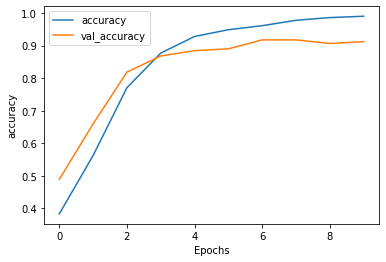

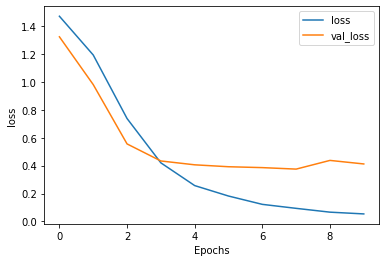

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
loss, accuracy = model.evaluate([X_test_input_ids, X_test_attention_mask], y_test)
print('Test accuracy :', accuracy)

6/6 [==============================] - 29s 5s/step - loss: 0.4122 - accuracy: 0.9121
Test accuracy : 0.9120879173278809
